<h1><font color="#7F000E" size=5> Maestria - Ciencias de la Computación</font></h1>

<h1><font color="#7F000R" size=6> Pose Estimation en la Clasificación de Posiciones de Yoga  </font></h1>

<br>
<div style="text-align:right">
<font color="#7F000E" size=3> Cadillo, Isabel</font>
<br>
<font color="#7F000E" size=3> Oscanoa, Hernan </font>
<br>
<font color="#7F000E" size=3> Valdez, Alexander</font>
<br>
<br>
<font color="#7F000E" size=3> Curso: Procesamiento de Imágenes</font>
</div>


---

## **Estimación de pose (también conocida como Detección de puntos clave).** ##

La estimación de pose es un problema general en la visión por computadora donde **detectamos la posición y orientación de un objeto**. Por lo general, esto significa detectar ubicaciones de puntos clave que describen el objeto. Por ejemplo, en el problema de la estimación de la pose de la cara (también conocida como detección de puntos de referencia faciales), detectamos puntos de referencia en un rostro humano.

**En el presente avance**  nos centraremos en la estimación de la postura humana, donde es necesario detectar y localizar las principales partes / articulaciones del cuerpo (por ejemplo, hombros, tobillos, rodillas, muñecas, etc.).

Una salida tipica de un estimadador de pose es la que se muestra acontinuacion:


**Fig1.** Salida de muestra de esqueleto de estimación de pose.
Creditos: Trabajador del ROJ -Americo. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
%cd drive/MyDrive/PI

/content/drive/MyDrive/PI


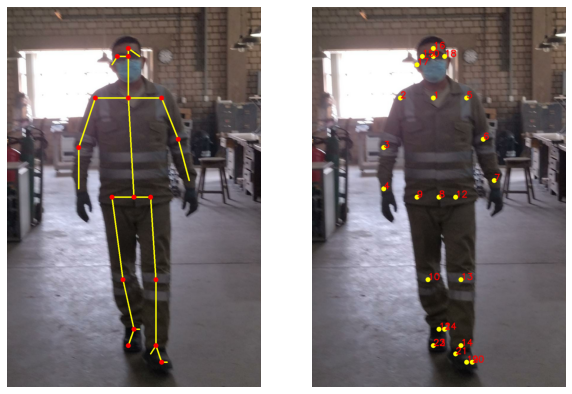

In [ ]:
# Tecnico del ROJ-Americo
from IPython import display 
display.Image("americo_pose1.png")

---

 # Caracteristicas de la PC

Un tema importante a tomar en cuenta durante el desarrollo de este cuaderno, es la capacidad computacional. 
Durante las pruebas se utilizo una pc con la siguiente cantidad de procesadores. Se intento trabajar con una laptop quadcore pero los resultados tardaban demasiado.

In [ ]:
!lscpu | grep 'CPU(s)'

CPU(s):              2
On-line CPU(s) list: 0,1
NUMA node0 CPU(s):   0,1


## Conjuntos de datos de detección de puntos clave ##

Hasta hace poco, había poco progreso en la estimación de poses debido a la falta de conjuntos de datos de alta calidad. En los últimos años se han publicado algunos conjuntos de datos desafiantes que han facilitado a los investigadores atacar el problema con todo su poder intelectual.
Algunos de los conjuntos de datos son:

- Desafío COCO Keypoints
- Conjunto de datos de pose humana MPII
- Conjunto de datos de pose de VGG

Estos conjuntos de datos permitieron generar los modelos que se muestran a continuacion.

## PASO 1: Descarga de los Modelos

### Estimacion de pose-OpenPose para una sola persona basada en DNN de OpenCV ###

La version OpenCV4.0 puede **leer** directamente la API de los modelos CAffe, TensorFlow, ONNX y otros; ademas **usar** directamente el modulo DNN de OpenCV.
La prueba principal aqui consiste en el modulo DNN y el modulo OpenPose.
La ruta de descarga del modelo de cuerpo humano OpenPose. 

BODY25: http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/body_25/pose_iter_584000.caffemodel
<br>
<br>
COCO: http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel
<br>
<br>
MPI: http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel

### Pesos de los Modelos 

In [ ]:
!curl -O http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/body_25/pose_iter_584000.caffemodel

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 99.8M  100 99.8M    0     0  7755k      0  0:00:13  0:00:13 --:--:-- 11.4M


In [ ]:
!curl -O http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  199M  100  199M    0     0  11.2M      0  0:00:17  0:00:17 --:--:-- 12.8M


In [ ]:
!curl -O http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  196M  100  196M    0     0  13.7M      0  0:00:14  0:00:14 --:--:-- 17.9M


### Arquitectura de los Modelos

In [ ]:
!curl -O https://raw.githubusercontent.com/spmallick/learnopencv/master/OpenPose/pose/coco/pose_deploy_linevec.prototxt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46371  100 46371    0     0  1006k      0 --:--:-- --:--:-- --:--:-- 1029k


## Paso 2: Cargar Red ##

Estamos utilizando modelos entrenados en Caffe Deep Learning Framework. Los modelos Caffe tienen 2 archivos 

1. Archivo .prototxt que especifica la arquitectura de la red neuronal: cómo se organizan las diferentes capas, etc.
2. Archivo .caffemodel que almacena los pesos del modelo entrenado

Usaremos estos dos archivos para cargar la red en la memoria.

## Paso 3: Leer la imagen y preparar la entrada a la red ##


El marco de entrada que leemos usando OpenCV debe convertirse en un blob de entrada (como Caffe) para que pueda ser alimentado a la red. Esto se hace usando la función blobFromImage que convierte la imagen del formato OpenCV al formato blob de Caffe. Los parámetros se deben proporcionar en la función blobFromImage. Primero normalizamos los valores de los píxeles para que estén en (0,1). Luego especificamos las dimensiones de la imagen. A continuación, el valor medio a restar, que es (0,0,0). No es necesario intercambiar los canales R y B, ya que tanto OpenCV como Caffe usan el formato BGR.

# CODIGO - PROGRAMACION

In [ ]:
#!/usr/bin/python3
#!--*-- coding: utf-8 --*--
from __future__ import division
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import os


class general_pose_model(object):
    def __init__(self, modelpath, mode="BODY25"):
        # Especifique el modelo utilizado
        #   Body25: 25 points
        #   COCO:   18 points
        #   MPI:    15 points
        self.inWidth = 368
        self.inHeight = 368
        self.threshold = 0.1
        if mode == "BODY25":
            self.pose_net = self.general_body25_model(modelpath)
        elif mode == "COCO":
            self.pose_net = self.general_coco_model(modelpath)
        elif mode == "MPI":
            self.pose_net = self.get_mpi_model(modelpath)


    def general_body25_model(self, modelpath):
        self.num_points = 25
        self.point_pairs = [[1, 0], [1, 2], [1, 5], 
                            [2, 3], [3, 4], [5, 6], 
                            [6, 7], [0, 15], [15, 17], 
                            [0, 16], [16, 18], [1, 8],
                            [8, 9], [9, 10], [10, 11], 
                            [11, 22], [22, 23], [11, 24],
                            [8, 12], [12, 13], [13, 14], 
                            [14, 19], [19, 20], [14, 21]]
        prototxt   = os.path.join(
            modelpath, 
            "pose/body_25/pose_deploy.prototxt")
        caffemodel = os.path.join(
            modelpath, 
            "pose/body_25/pose_iter_584000.caffemodel")
        coco_model = cv2.dnn.readNetFromCaffe(prototxt, caffemodel)

        return coco_model

    def general_coco_model(self, modelpath):
        self.points_name = {
            "Nose": 0, "Neck": 1, 
            "RShoulder": 2, "RElbow": 3, "RWrist": 4,
            "LShoulder": 5, "LElbow": 6, "LWrist": 7, 
            "RHip": 8, "RKnee": 9, "RAnkle": 10, 
            "LHip": 11, "LKnee": 12, "LAnkle": 13, 
            "REye": 14, "LEye": 15, 
            "REar": 16, "LEar": 17, 
            "Background": 18}
        self.num_points = 18
        self.point_pairs = [[1, 0], [1, 2], [1, 5], 
                            [2, 3], [3, 4], [5, 6], 
                            [6, 7], [1, 8], [8, 9],
                            [9, 10], [1, 11], [11, 12], 
                            [12, 13], [0, 14], [0, 15], 
                            [14, 16], [15, 17]]
        prototxt   = os.path.join(modelpath,"pose/coco/pose_deploy_linevec.prototxt")
        caffemodel = os.path.join(modelpath, "pose/coco/pose_iter_440000.caffemodel")
        coco_model = cv2.dnn.readNet(prototxt, caffemodel)

        return coco_model
    
    def get_mpi_model(self, modelpath):
        self.points_name = { 
            "Head": 0, "Neck": 1, 
            "RShoulder": 2, "RElbow": 3, "RWrist": 4,
            "LShoulder": 5, "LElbow": 6, "LWrist": 
            7, "RHip": 8, "RKnee": 9, "RAnkle": 10, 
            "LHip": 11, "LKnee": 12, "LAnkle": 13, 
            "Chest": 14, "Background": 15 }
        self.num_points = 15
        self.point_pairs = [[0, 1], [1, 2], [2, 3], 
                            [3, 4], [1, 5], [5, 6], 
                            [6, 7], [1, 14],[14, 8], 
                            [8, 9], [9, 10], [14, 11], 
                            [11, 12], [12, 13]
                            ]
        prototxt = os.path.join(modelpath,"pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt")
        caffemodel = os.path.join(modelpath,"pose/mpi/pose_iter_160000.caffemodel")
        mpi_model = cv2.dnn.readNetFromCaffe(prototxt, caffemodel)

        return mpi_model

    def predict(self, imgfile):
        img_cv2 = cv2.imread(imgfile)
        print("Tipo",type(img_cv2))
        img_height, img_width, _ = img_cv2.shape
        inpBlob = cv2.dnn.blobFromImage(img_cv2, 
                                        1.0 / 255, 
                                        (self.inWidth, self.inHeight),
                                        (0, 0, 0), 
                                        swapRB=False, 
                                        crop=False)
        self.pose_net.setInput(inpBlob)
        self.pose_net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        self.pose_net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

        output = self.pose_net.forward()

        H = output.shape[2]
        W = output.shape[3]
        print(output.shape)

        # vis heatmaps
        self.vis_heatmaps(img_file, output)

        #
        points = []
        for idx in range(self.num_points):
            probMap = output[0, idx, :, :] # confidence map.

            # Find global maxima of the probMap.
            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

            # Scale the point to fit on the original image
            x = (img_width * point[0]) / W
            y = (img_height * point[1]) / H

            if prob > self.threshold:
                points.append((int(x), int(y)))
            else:
                points.append(None)

        return points

    
    def predict_only(self, imgfile):
        img_cv2 = cv2.imread(imgfile)
        print("Tipo",type(img_cv2))
        img_height, img_width, _ = img_cv2.shape
        inpBlob = cv2.dnn.blobFromImage(img_cv2, 
                                        1.0 / 255, 
                                        (self.inWidth, self.inHeight),
                                        (0, 0, 0), 
                                        swapRB=False, 
                                        crop=False)
        self.pose_net.setInput(inpBlob)
        self.pose_net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        self.pose_net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

        output = self.pose_net.forward()

        H = output.shape[2]
        W = output.shape[3]
        print(output.shape)

        # vis heatmaps
        # self.vis_heatmaps(img_file, output)

        #
        points = []
        for idx in range(self.num_points):
            probMap = output[0, idx, :, :] # confidence map.

            # Find global maxima of the probMap.
            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

            # Scale the point to fit on the original image
            x = (img_width * point[0]) / W
            y = (img_height * point[1]) / H

            if prob > self.threshold:
                points.append((int(x), int(y)))
            else:
                points.append(None)

        return points


    def vis_heatmaps(self, imgfile, net_outputs):
        img_cv2 = cv2.imread(imgfile)
        plt.figure(figsize=[10, 10])

        for pdx in range(self.num_points):
            probMap = net_outputs[0, pdx, :, :]
            probMap = cv2.resize(
                probMap, 
                (img_cv2.shape[1], img_cv2.shape[0])
            )
            plt.subplot(5, 5, pdx+1)
            plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
            plt.imshow(probMap, alpha=0.6)
            plt.colorbar()
            plt.axis("off")
        plt.show()

    def vis_pose(self, imgfile, points):
        img_cv2 = cv2.imread(imgfile)
        img_cv2_copy = np.copy(img_cv2)
        for idx in range(len(points)):
            if points[idx]:
                cv2.circle(img_cv2_copy, 
                           points[idx], 
                           8, 
                           (0, 255, 255), 
                           thickness=-1,
                           lineType=cv2.FILLED)
                cv2.putText(img_cv2_copy, 
                            "{}".format(idx), 
                            points[idx], 
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1, 
                            (0, 0, 255), 
                            2, 
                            lineType=cv2.LINE_AA)

        # Draw Skeleton
        for pair in self.point_pairs:
            partA = pair[0]
            partB = pair[1]

            if points[partA] and points[partB]:
                cv2.line(img_cv2, 
                         points[partA], 
                         points[partB], 
                         (0, 255, 255), 3)
                cv2.circle(img_cv2, 
                           points[partA], 
                           8, 
                           (0, 0, 255), 
                           thickness=-1, 
                           lineType=cv2.FILLED)

        plt.figure(figsize=[10, 10])
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img_cv2_copy, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()


## BODY - 25 PUNTOS ##

[INFO]Model loads time:  0.27912187576293945
Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46)


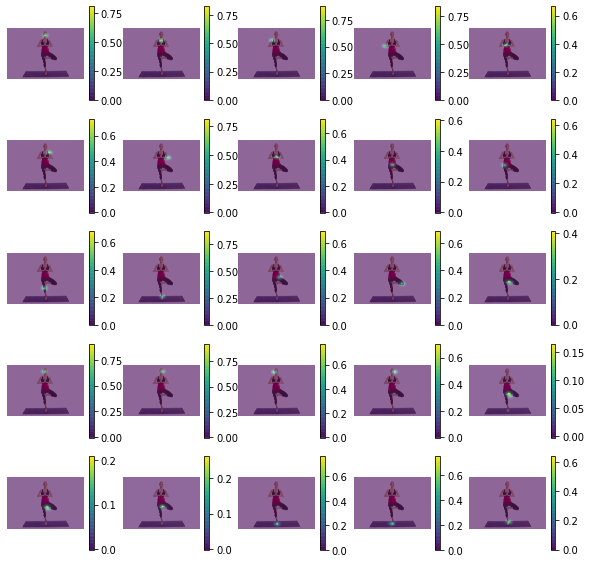

[INFO]Model predicts time:  16.88465118408203


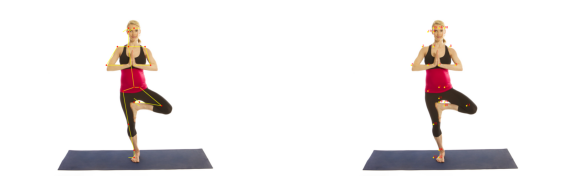

In [ ]:
img_file='/content/drive/MyDrive/PI/DATASET/TEST/tree/00000043.jpg'
start = time.time()

modelpath = "openpose_models"
pose_model = general_pose_model(modelpath, mode="BODY25")
print("[INFO]Model loads time: ", time.time() - start)

start = time.time()
res_points = pose_model.predict(img_file)
print("[INFO]Model predicts time: ", time.time() - start)
pose_model.vis_pose(img_file, res_points)

## COCO - 18 PUNTOS 

[INFO]Pose estimation.
[INFO]Model loads time:  5.114247798919678
Tipo <class 'numpy.ndarray'>
(1, 57, 46, 46)


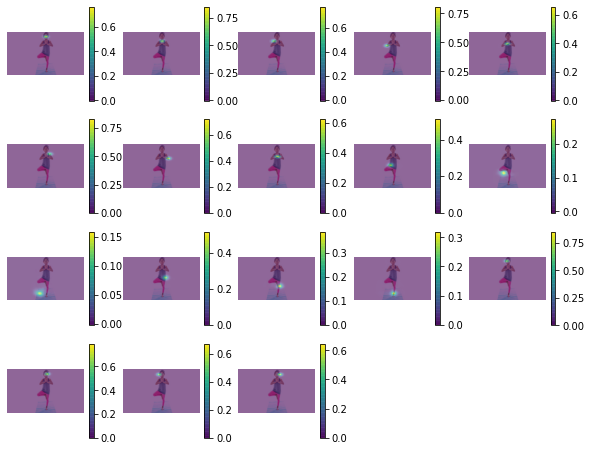

[INFO]Model predicts time:  9.854108810424805


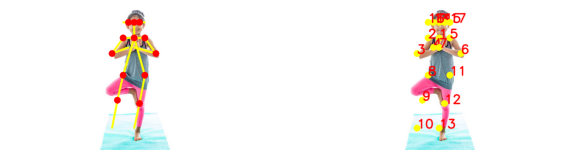

In [ ]:
img_file='/content/drive/MyDrive/PI/DATASET/TRAIN/tree/00000108.jpg'

print("[INFO]Pose estimation.")

start = time.time()
modelpath = "openpose_models"
pose_model = general_pose_model(modelpath, mode="COCO")
print("[INFO]Model loads time: ", time.time() - start)

start = time.time()
res_points = pose_model.predict(img_file)
print("[INFO]Model predicts time: ", time.time() - start)
pose_model.vis_pose(img_file, res_points)

## MPI - 15 PUNTOS ##

[INFO]Model loads time:  4.699365854263306
Tipo <class 'numpy.ndarray'>
(1, 44, 46, 46)


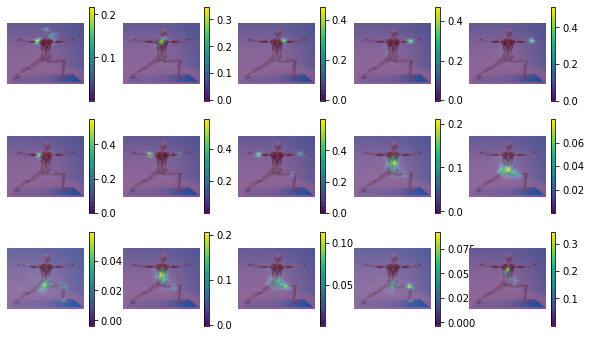

[INFO]Model predicts time:  7.2238078117370605


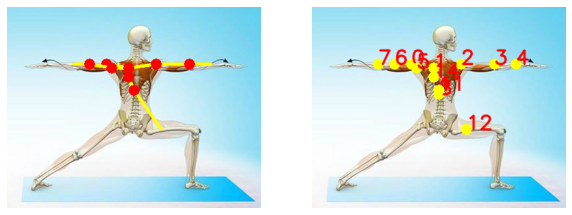

In [ ]:
img_file='/content/drive/MyDrive/PI/DATASET/TRAIN/warrior2/00000142.jpg'
start = time.time()

modelpath = "openpose_models"
pose_model = general_pose_model(modelpath, mode="MPI")
print("[INFO]Model loads time: ", time.time() - start)

start = time.time()
res_points = pose_model.predict(img_file)
print("[INFO]Model predicts time: ", time.time() - start)
pose_model.vis_pose(img_file, res_points)

# Estimación de Poses de Yoga

## Dataset y Preprocesamiento

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from random import choice
import os
from tqdm import tqdm
%matplotlib inline

In [ ]:
def norma(points):
  p = []
  for i in range(25):
    if points[i] != None:
      x= points[i][0]
      y= points[i][1]
      n = math.sqrt(x**2+y**2)
      p.append(n)
    else:
      p.append(None)
  return p

In [ ]:
def tag(s):
  t = s[s.rindex('/')+1:]
  if t == 'goddess':
    v=1
  elif t == 'plank':
    v=2
  elif t == 'tree':
    v=3
  else:
    v=4
  return v

In [ ]:
rootdir = 'DATASET'
pose_model = general_pose_model(modelpath, mode="BODY25")

dict = {}

index = 0
for subdir, dirs, files in tqdm(os.walk(rootdir)):
    for file in files:                
          img_file = os.path.join(subdir, file)   
          points = pose_model.predict_only(img_file)
          row = norma(points)          
          row.append(tag(subdir))
          print(row)
          dict['row_'+str(index)] = row          
          index+=1
print(dict)         

0it [00:00, ?it/s]

Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46)
[487.7550614806575, 550.8983572311683, 593.2731242859396, 663.4342469303194, 738.9106847244801, 535.0084111488342, 478.1683803849853, None, 743.3895344972244, 730.0, 879.0500554575946, 989.2320253610878, 749.9873332263686, 877.0461789438456, 980.7201435679804, 498.6551914900716, 487.7550614806575, 520.5247352431967, 477.7970280359642, 1036.881864052024, 1028.7643073124184, 1004.6392387319938, 1020.9079292472951, 1029.5693274374485, 1012.9501468483037, 2]
Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46)
[1410.332230362761, 1337.0673131895792, 1274.6548552451366, 1132.4720747108954, 1093.7591142477397, 1382.985177071685, 1420.0327461013003, 1501.5325504297268, 1115.6330041729673, 1044.7889739081286, 943.8273147138729, 922.8672710633962, 1172.4035141537233, 1041.0235347964042, 966.8298712803613, 1433.240035723256, 1451.704170965972, 1392.0793799205562, 1471.3752070766993, 926.6461028893393, 949.0732321586148, 980.5860492582995, 896.8439106109826, 8

3it [01:08, 22.81s/it]

(1, 78, 46, 46)
[903.6924255519684, 863.3799858694896, 890.1887440312869, 970.7816438314024, 1070.4601814173193, 839.5004466943421, 818.8852178419146, 842.7318672033234, 701.6701504268227, 743.790965258385, 724.6385305792123, 735.8620794687005, 658.9764790946639, 653.7927806270118, 719.4025298815677, None, 903.6924255519684, None, 917.7390696706772, 679.1590388119707, 691.3327708130145, 729.8664261356321, None, None, 753.3160027505057, 2]
Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46)
[643.9440969525227, 737.2001085187115, 643.0031104123836, 739.1380114701178, 791.3058827027637, 860.2371765972451, 1025.2902028206454, 869.0466040437648, None, None, None, None, None, None, None, 607.6158325784476, 653.5028691597306, 576.9055381949457, 699.8121176430143, None, None, None, None, None, None, 3]
Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46)
[537.5872022286245, 569.8780571315235, 524.1068593330943, 528.3190324037172, 554.6674679481391, 613.8615479079953, 650.459837345858, 579.1200221024999, 589.

4it [02:15, 37.11s/it]

(1, 78, 46, 46)
[733.9128013599436, 816.6663945577778, 691.4448640347255, 785.5660379624363, 924.4555154251609, 975.7561170702442, 1234.91902568549, 992.0246972732081, 1193.7043184976756, 1106.3475945651078, 1144.5776513631567, 1367.9228779430514, 1300.0680751406828, 1605.7210218465723, 1906.5384863673746, 695.8290019825273, 753.8255766422362, 676.8256791818703, 820.5394566990669, 2032.2118491928936, 2032.2118491928936, 1938.3069932288847, 1460.5375722657736, 1460.5375722657736, 1343.5542415548396, 3]
Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46)
[1524.1499270084948, 1707.0328057773231, 1509.5221098082664, 1187.0770825856255, 857.8636255256426, 1839.4183863384644, None, None, 1946.2630860189483, 1808.849634436207, 1640.9219969273372, 1962.449489795852, 2116.5273444961676, 2496.4358593803286, 2878.3675929248507, 1517.9502626897893, 1586.4740779476986, None, 1728.106767534923, 2988.4318630345247, 3016.584989686185, 2878.3675929248507, 1971.6959704782073, 1971.6959704782073, 2032.685415896

5it [05:18, 83.11s/it]

(1, 78, 46, 46)
[409.6840245848012, 388.64122272347794, 346.18203304042225, None, None, 446.07734755308974, None, None, 470.8046303935423, 447.5991510268982, None, None, 494.2226219023164, None, None, 409.6840245848012, 406.5464303127012, 364.45301480437774, None, None, None, None, None, None, None, 4]
Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46)
[211.26523613694707, 207.46565980903924, 183.8096841844847, 154.45711378890906, 111.83022847155415, 231.62469643800938, 285.616876252087, 300.8421513019743, 254.57415422622933, 242.71176320895532, 242.88680491125902, 331.8327892177022, 273.76632371422164, 340.03676271838606, 388.7428455933305, 202.09156340629363, 218.92921230388603, 185.72291188757515, None, 417.3871104861768, 412.3166259078089, 394.8670662387533, 338.11980125393427, 330.3891644712338, 338.42281246984516, 1]
Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46)
[666.7600767892451, None, 655.2098900352466, None, None, None, None, None, 773.1558704426941, 726.2403183519901, 737.808240669

6it [06:59, 88.64s/it]

(1, 78, 46, 46)
[544.6145425895272, 568.8338949113353, 506.4632267006164, 405.84849389889325, 314.8745782053546, 658.729838401146, 775.4069899091702, 795.4633869638501, 684.9795617388887, 634.1372091274884, 635.3243266238119, 796.2474489755053, 749.0060079865848, 908.8740286750414, 1069.640126397659, 541.3658651965416, 566.202260680757, 500.569675469859, 587.8205508486412, 1126.361398486294, 1142.5349009986521, 1065.6157844176296, 806.781878824754, 806.781878824754, 821.5168896620446, 1]
Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46)
[445.8261993198695, 516.9487402054482, 505.4305095658552, 460.92515661439006, 417.1953978653168, 558.8309225517143, 641.775661738586, 717.8439941937245, 659.939391156491, 661.9365528508, 653.1592455136803, 771.3475221973556, 685.6238035541065, 824.1965784932621, 988.0005060727449, None, 439.3278957680698, None, 459.8271414346917, 1014.4003154573642, 1014.4003154573642, 997.6697850491414, 781.5529412650176, 781.5529412650176, 794.547040772288, 4]
Tipo <class 

8it [14:29, 152.73s/it]

(1, 78, 46, 46)
[128.73616430514, 153.9415473483361, 137.7425134081704, 101.51354589413178, 74.24957912338628, 172.67889274604468, 203.16003544004417, 228.23233776132602, 192.09372712298546, 176.91806012954132, 166.13849644197458, 210.48752932181043, 202.4080037943164, 248.47736315407084, 303.3232599059953, 127.34991166074674, 134.12307780542466, None, 146.75830470538966, 309.127805284481, 311.2715855968868, 308.75556675143525, 210.16184239771025, 205.36065835500236, 214.1611542740653, 4]
Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46)
[335.19546536312214, 368.70177650778953, 374.1924638471491, 416.04326698073123, None, 365.042463283383, 400.03124877939223, None, 483.66207211233757, 486.4894654563447, 571.9090836837618, 669.7648841197932, 481.48624071721923, 581.7508057579294, 675.953400760733, 324.9015235421342, 324.9015235421342, 329.8620923962012, None, 700.7517392058331, 693.9293912207495, 687.8211976960291, 700.7517392058331, 689.1066680855729, 682.1678679034949, 2]
Tipo <class 'nump

9it [16:29, 144.48s/it]

(1, 78, 46, 46)
[266.58019431308094, 271.6265819097976, 286.2621176474456, None, 370.84363281577316, 278.78665678256556, None, None, 367.29960522712247, 374.2325480232846, 447.9877230460674, 549.156626109528, 367.29960522712247, 440.75957164876183, 537.5360453030104, None, 257.57717290163737, None, 252.48564315620007, 562.1743501797285, 557.5733135651311, 553.6108741706579, None, 557.5733135651311, 564.4129693761474, 2]
Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46)
[811.9667480876295, 916.3110825478431, 774.8044914686543, 925.5765770588623, 961.2013316678249, 1095.4569822681308, 1335.5661720783437, 1042.8365164300683, 1315.464936818918, 1242.00644120713, 1318.3209017534389, 1453.1242204298985, 1411.4506721809303, 1727.6356676105063, 2020.639750178146, 779.4312028652689, 844.5383354235614, 723.2461545006652, 918.4143944864976, 2115.505849672839, 2128.219913448796, 2007.9633960807155, 1563.0598197126046, 1547.8375237730866, 1446.123092962698, 3]
Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46

10it [18:01, 130.64s/it]

(1, 78, 46, 46)
[114.38968484964018, 136.49908424601244, 120.21647141718975, 156.0833110873805, 115.67627241573788, 158.38244852255568, 207.88939366884497, 233.95084953895764, 235.76471322061747, 226.24102192131292, None, None, 252.4480144505003, None, None, 103.73041983911952, 116.09048195265622, 98.84331034521254, 124.72369462135092, None, None, None, None, None, None, 3]
Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46)
[43.46262762420146, 44.94441010848846, 41.617304093369626, 46.66904755831214, None, 48.30113870293329, None, None, 55.90169943749474, 53.2634959423431, None, None, 57.982756057296896, None, None, 40.85339643163099, 42.720018726587654, 39.0, 43.657759905886145, None, None, None, None, None, None, 1]
Tipo <class 'numpy.ndarray'>
(1, 78, 46, 46)
[300.56779601281306, 310.517310306527, 275.3633962602873, 229.61271741782946, 199.2234925906079, 345.3259329966401, 389.7550512822124, 381.9803659875727, 365.5680511204446, 345.2028389222777, 331.36837507523256, 395.83456140160376, 3

11it [21:10, 115.53s/it]

(1, 78, 46, 46)
[629.6673725071039, 648.4720502843588, 599.7707895521421, 559.128786595718, 511.8456798684541, 696.8644057490668, 779.3773155538978, 758.2380892569299, 711.8209044415596, 689.2154960533027, 622.9454229705841, 707.8566239006315, 756.1699544414602, 837.2574275573792, 888.2206932964352, 625.8466265787489, 650.8148738312609, 603.9950330921605, 679.4004710036636, 925.5765770588623, 925.5765770588623, 875.2234000528093, 710.715836322788, 700.2578096672681, 717.9310551856634, 1]
{'row_0': [487.7550614806575, 550.8983572311683, 593.2731242859396, 663.4342469303194, 738.9106847244801, 535.0084111488342, 478.1683803849853, None, 743.3895344972244, 730.0, 879.0500554575946, 989.2320253610878, 749.9873332263686, 877.0461789438456, 980.7201435679804, 498.6551914900716, 487.7550614806575, 520.5247352431967, 477.7970280359642, 1036.881864052024, 1028.7643073124184, 1004.6392387319938, 1020.9079292472951, 1029.5693274374485, 1012.9501468483037, 2], 'row_1': [1410.332230362761, 1337.067

In [ ]:
columns = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23','p24', 'pose']
df = pd.DataFrame.from_dict(dict, orient='index', columns=columns)

In [ ]:
df.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,pose
row_0,487.755061,550.898357,593.273124,663.434247,738.910685,535.008411,478.168380,NaN,743.389534,730.000000,879.050055,989.232025,749.987333,877.046179,980.720144,498.655191,487.755061,520.524735,477.797028,1036.881864,1028.764307,1004.639239,1020.907929,1029.569327,1012.950147,2
row_1,1410.332230,1337.067313,1274.654855,1132.472075,1093.759114,1382.985177,1420.032746,1501.532550,1115.633004,1044.788974,943.827315,922.867271,1172.403514,1041.023535,966.829871,1433.240036,1451.704171,1392.079380,1471.375207,926.646103,949.073232,980.586049,896.843911,896.843911,912.934280,2
row_2,3255.811112,3003.016650,2868.071477,2754.426619,2496.673387,3329.961111,3582.823468,3969.703767,2591.693076,2378.471988,2596.713692,NaN,2798.245879,2859.819575,NaN,3297.982565,3360.531654,3194.621887,3426.997811,NaN,NaN,NaN,NaN,NaN,NaN,2
row_3,197.101497,240.154117,275.617489,336.293027,393.153914,211.340957,158.549677,121.708669,340.471732,349.448136,449.480812,539.000928,331.905107,442.648845,533.577548,193.878828,197.101497,225.497228,NaN,553.823979,548.000000,539.557226,559.697240,553.138319,546.298453,2
row_4,NaN,593.808892,579.332374,NaN,NaN,588.809816,622.945423,652.449232,704.386968,720.147207,821.822365,917.041439,689.215496,807.172844,924.431176,NaN,NaN,535.583794,522.603100,931.429010,931.429010,924.431176,946.526809,939.310918,939.310918,2


In [ ]:
df.to_csv("dict.csv")

# Tratamiento de NaN

In [ ]:
df[['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23','p24']] = df[['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23','p24']].fillna(value=df[['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23','p24']].mean())
df.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,pose
row_0,487.755061,550.898357,593.273124,663.434247,738.910685,535.008411,478.168380,743.174575,743.389534,730.000000,879.050055,989.232025,749.987333,877.046179,980.720144,498.655191,487.755061,520.524735,477.797028,1036.881864,1028.764307,1004.639239,1020.907929,1029.569327,1012.950147,2
row_1,1410.332230,1337.067313,1274.654855,1132.472075,1093.759114,1382.985177,1420.032746,1501.532550,1115.633004,1044.788974,943.827315,922.867271,1172.403514,1041.023535,966.829871,1433.240036,1451.704171,1392.079380,1471.375207,926.646103,949.073232,980.586049,896.843911,896.843911,912.934280,2
row_2,3255.811112,3003.016650,2868.071477,2754.426619,2496.673387,3329.961111,3582.823468,3969.703767,2591.693076,2378.471988,2596.713692,790.480413,2798.245879,2859.819575,923.414199,3297.982565,3360.531654,3194.621887,3426.997811,975.570842,974.866535,935.773170,789.259465,794.178324,803.796739,2
row_3,197.101497,240.154117,275.617489,336.293027,393.153914,211.340957,158.549677,121.708669,340.471732,349.448136,449.480812,539.000928,331.905107,442.648845,533.577548,193.878828,197.101497,225.497228,569.461772,553.823979,548.000000,539.557226,559.697240,553.138319,546.298453,2
row_4,552.251399,593.808892,579.332374,508.369163,485.740801,588.809816,622.945423,652.449232,704.386968,720.147207,821.822365,917.041439,689.215496,807.172844,924.431176,555.619286,552.730714,535.583794,522.603100,931.429010,931.429010,924.431176,946.526809,939.310918,939.310918,2


In [ ]:
df.to_csv("dataset.csv")

## Split Train Test

In [ ]:
df = pd.read_csv("dataset.csv")
df = df[['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23','p24', 'pose']]
df

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,pose
0,487.755061,550.898357,593.273124,663.434247,738.910685,535.008411,478.168380,743.174575,743.389534,730.000000,879.050055,989.232025,749.987333,877.046179,980.720144,498.655191,487.755061,520.524735,477.797028,1036.881864,1028.764307,1004.639239,1020.907929,1029.569327,1012.950147,2
1,1410.332230,1337.067313,1274.654855,1132.472075,1093.759114,1382.985177,1420.032746,1501.532550,1115.633004,1044.788974,943.827315,922.867271,1172.403514,1041.023535,966.829871,1433.240036,1451.704171,1392.079380,1471.375207,926.646103,949.073232,980.586049,896.843911,896.843911,912.934280,2
2,3255.811112,3003.016650,2868.071477,2754.426619,2496.673387,3329.961111,3582.823468,3969.703767,2591.693076,2378.471988,2596.713692,790.480413,2798.245879,2859.819575,923.414199,3297.982565,3360.531654,3194.621887,3426.997811,975.570842,974.866535,935.773170,789.259465,794.178324,803.796739,2
3,197.101497,240.154117,275.617489,336.293027,393.153914,211.340957,158.549677,121.708669,340.471732,349.448136,449.480812,539.000928,331.905107,442.648845,533.577548,193.878828,197.101497,225.497228,569.461772,553.823979,548.000000,539.557226,559.697240,553.138319,546.298453,2
4,552.251399,593.808892,579.332374,508.369163,485.740801,588.809816,622.945423,652.449232,704.386968,720.147207,821.822365,917.041439,689.215496,807.172844,924.431176,555.619286,552.730714,535.583794,522.603100,931.429010,931.429010,924.431176,946.526809,939.310918,939.310918,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,215.371772,235.467620,214.597297,188.679623,144.059016,257.614052,312.313945,297.015151,312.385979,308.650288,322.094707,399.712397,325.262971,403.193502,460.135850,203.494472,216.226733,198.070694,221.930169,498.414486,490.404935,464.631036,404.487330,394.575722,401.449872,1
532,428.621045,507.645546,468.192268,417.579932,307.688154,563.585841,636.898736,600.083328,706.629323,683.915931,704.029119,858.655926,733.426206,704.029119,858.655926,404.030939,425.734659,399.299386,460.678847,893.955256,893.955256,882.715130,893.955256,893.955256,882.715130,1
533,629.667373,648.472050,599.770790,559.128787,511.845680,696.864406,779.377316,758.238089,711.820904,689.215496,622.945423,707.856624,756.169954,837.257428,888.220693,625.846627,650.814874,603.995033,679.400471,925.576577,925.576577,875.223400,710.715836,700.257810,717.931055,1
534,378.450789,396.939542,353.305817,303.146829,258.154992,440.545117,522.269088,521.471955,452.823365,427.449412,401.687690,476.668648,491.495676,569.139702,634.574661,375.694024,390.283230,363.044074,408.431145,679.036082,679.036082,641.599564,464.624580,464.624580,486.230398,1


In [ ]:
X = np.array(df[['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23','p24']])
y = np.array(df['pose'])

In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

## Escalamos para uniformizar

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer

scalify = StandardScaler()
X_train_prepared = scalify.fit_transform(X_train)
X_test_prepared = scalify.transform(X_test)

## Modelo y Entrenamiento

In [ ]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Initialize the three models
random_state = 42

sgd_clf = SGDClassifier(random_state=random_state, max_iter=1000, tol=1e-3)
clf_A = RandomForestClassifier(random_state=random_state)
clf_B = GaussianNB()
clf_C = SVC(random_state=random_state)
clf_E = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=100, random_state=1)

sgd_clf.fit(X_train_prepared, y_train)
clf_A.fit(X_train_prepared, y_train)
clf_B.fit(X_train_prepared, y_train)
clf_C.fit(X_train_prepared, y_train)
clf_E.fit(X_train_prepared, y_train)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=100, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

## Test

In [ ]:
y_pred_SGD= sgd_clf.predict(X_test_prepared)
y_pred_RF= clf_A.predict(X_test_prepared)
y_pred_GNB= clf_B.predict(X_test_prepared)
y_pred_SVC= clf_C.predict(X_test_prepared)
y_pred_Red= clf_E.predict(X_test_prepared)

print('Percentage correct: ', 100*np.sum(y_pred_SGD == y_test)/len(y_test))
print('Percentage correct: ', 100*np.sum(y_pred_RF == y_test)/len(y_test))
print('Percentage correct: ', 100*np.sum(y_pred_GNB == y_test)/len(y_test))
print('Percentage correct: ', 100*np.sum(y_pred_SVC == y_test)/len(y_test))
print('Percentage correct: ', 100*np.sum(y_pred_Red == y_test)/len(y_test))

Percentage correct:  50.925925925925924
Percentage correct:  80.55555555555556
Percentage correct:  44.44444444444444
Percentage correct:  56.48148148148148
Percentage correct:  85.18518518518519


## Results

In [ ]:
from sklearn.metrics import confusion_matrix

cmx_SGD = confusion_matrix(y_test, y_pred_SGD)
cmx_RF = confusion_matrix(y_test, y_pred_RF)
cmx_GNB = confusion_matrix(y_test, y_pred_GNB)
cmx_SVC = confusion_matrix(y_test, y_pred_SVC)
cmx_RED = confusion_matrix(y_test, y_pred_Red)
cmx_RED

array([[25,  0,  0,  2],
       [ 1, 12,  1,  2],
       [ 1,  1, 11,  1],
       [ 3,  2,  2, 44]])

Confusion matrix, without normalization
[[25  0  0  2]
 [ 1 12  1  2]
 [ 1  1 11  1]
 [ 3  2  2 44]]
Normalized confusion matrix
[[0.92592593 0.         0.         0.07407407]
 [0.0625     0.75       0.0625     0.125     ]
 [0.07142857 0.07142857 0.78571429 0.07142857]
 [0.05882353 0.03921569 0.03921569 0.8627451 ]]


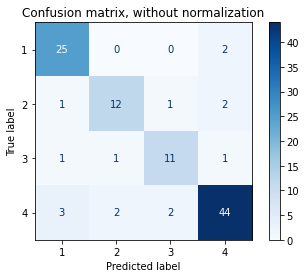

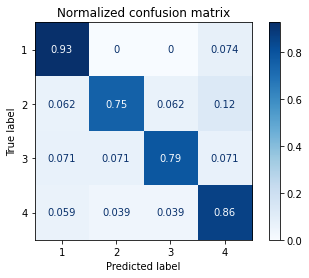

In [ ]:
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_E, X_test_prepared, y_test,
                                cmap=plt.cm.Blues, normalize = normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


 [1, 2, 3, 4]


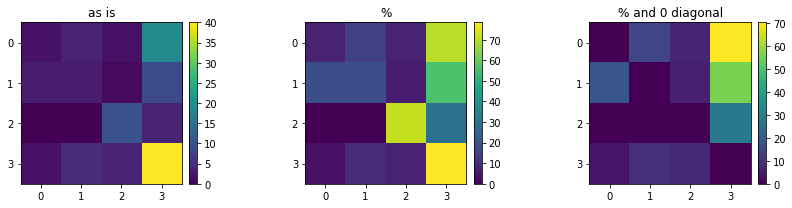

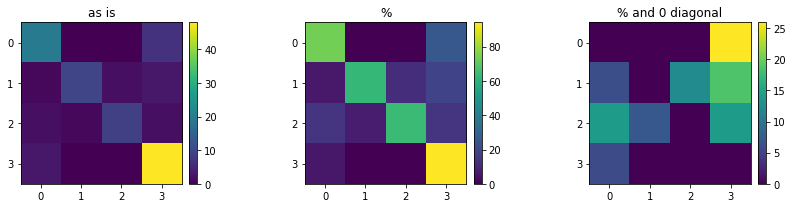

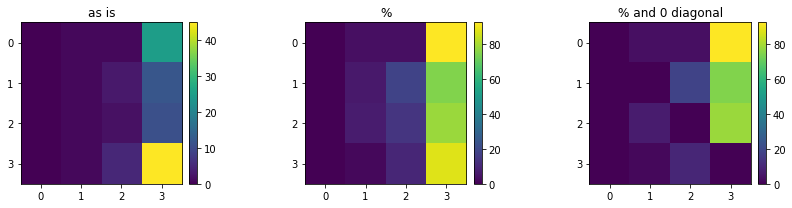

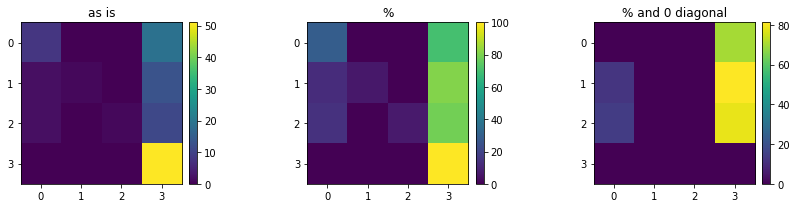

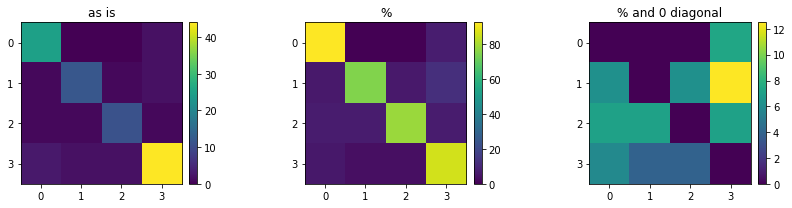

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx_SGD)
plot_confusion_matrix(cmx_RF)
plot_confusion_matrix(cmx_GNB)
plot_confusion_matrix(cmx_SVC)
plot_confusion_matrix(cmx_RED)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

## Mejora

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
YOGA_pipeline = Pipeline([
    ('scalify', StandardScaler()),
    ('mlp', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=100, random_state=1))
])
 
clf = YOGA_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  85.18518518518519


In [ ]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'mlp__solver': ['sgd', 'lbfgs'],
        'mlp__alpha':[1e-5, 1e-6, 1e-7],
        'mlp__hidden_layer_sizes': [50, 80, 100, 120, 200],
        'mlp__random_state': [1, 20, 50],
        'mlp__max_iter': [100,200,300]
    }
]

In [ ]:
grid_search = GridSearchCV(YOGA_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  2.8min finished


In [ ]:
grid_res.best_estimator_

Pipeline(memory=None,
         steps=[('scalify',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('mlp',
                 MLPClassifier(activation='relu', alpha=1e-06,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=120, learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=20, shuffle=True, solver='lbfgs',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [ ]:
grid_res.best_score_

0.8528677894875077

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(grid_res.best_params_)

{   'mlp__alpha': 1e-06,
    'mlp__hidden_layer_sizes': 120,
    'mlp__max_iter': 200,
    'mlp__random_state': 20,
    'mlp__solver': 'lbfgs'}


In [ ]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  87.03703703703704


Confusion matrix, without normalization
[[23  0  0  4]
 [ 1 13  0  2]
 [ 1  0 12  1]
 [ 2  2  1 46]]
Normalized confusion matrix
[[0.85185185 0.         0.         0.14814815]
 [0.0625     0.8125     0.         0.125     ]
 [0.07142857 0.         0.85714286 0.07142857]
 [0.03921569 0.03921569 0.01960784 0.90196078]]


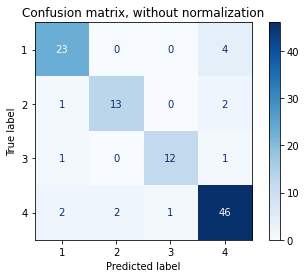

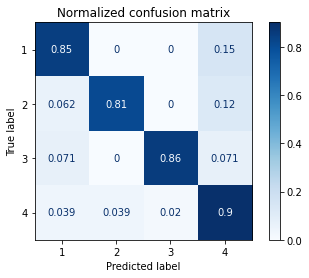

In [ ]:
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(grid_res, X_test, y_test,
                                cmap=plt.cm.Blues, normalize = normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()